In [2]:
# For some reason, the cloudy class images are all in CMYK and have 4 channels, so this was run to ensure that all of them have 3 channels and are in RGB
from PIL import Image
import os
for file in os.listdir('./data/cloudy/'):
    image = Image.open('./data/cloudy/' + file).convert('RGB')
    image.save('./data/cloudy/' + file, 'JPEG', quality=100)
  

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

In [411]:
IMG_DIM = 100
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [412]:
# Load the dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    './data/',
    batch_size=BATCH_SIZE,
    image_size=(IMG_DIM, IMG_DIM),
    shuffle=True
)

Found 5631 files belonging to 4 classes.


In [413]:
CLASS_NAMES = dataset.class_names
CLASS_NAMES

['cloudy', 'desert', 'green_area', 'water']

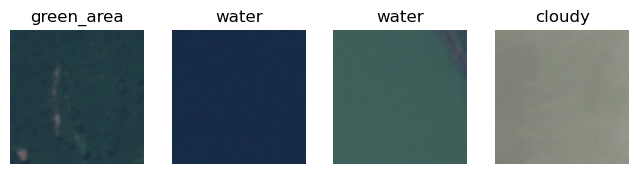

In [414]:
# Preview the first 16 images with their labels
plt.figure(figsize=(8, 8))
for image_batch, label_batch in dataset.take(1):
    for i in range(4):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype(np.uint8))
        plt.title(CLASS_NAMES[label_batch[i]])
        plt.axis('off')

In [415]:
# Split dataset into training, cross validation and testing subsets -- 80 10 10 split
train_size = int(0.8 * len(dataset))
cv_size = int(0.1 * len(dataset))

train_ds = dataset.take(train_size)
cv_ds = dataset.skip(train_size).take(cv_size)
test_ds = dataset.skip(train_size).skip(cv_size)

In [416]:
# Create a preprocessing layer for resizing and rescaling
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_DIM, IMG_DIM),
    layers.experimental.preprocessing.Rescaling(1. / 255.),
])

In [417]:
# Create a data augmentation layer
data_augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.5)
])

In [418]:
# Prefetch and cache datasets to improve performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
cv_ds = cv_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [419]:
# Data augmentation
train_ds = train_ds.map(
    lambda x, y: (data_augment(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [421]:
# Build the neural network
input_shape = (BATCH_SIZE, IMG_DIM, IMG_DIM, CHANNELS)
model = models.Sequential([
    resize_rescale,
    
    layers.Conv2D(128, (1, 1), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (1, 1), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (1, 1), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
    
    layers.Dense(256, activation='relu'),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
])

model.build(input_shape=input_shape)

In [422]:
model.summary()

Model: "sequential_149"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_146 (Sequential  (32, 100, 100, 3)         0         
 )                                                               
                                                                 
 conv2d_389 (Conv2D)         (32, 100, 100, 128)       512       
                                                                 
 max_pooling2d_388 (MaxPool  (32, 50, 50, 128)         0         
 ing2D)                                                          
                                                                 
 conv2d_390 (Conv2D)         (32, 48, 48, 64)          73792     
                                                                 
 max_pooling2d_389 (MaxPool  (32, 24, 24, 64)          0         
 ing2D)                                                          
                                                    

In [423]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [424]:
# Fit and record the epochs
epochs = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=cv_ds
)

Epoch 1/50
140/140 [==============================] - 5s 22ms/step - loss: 0.6302 - accuracy: 0.6411 - val_loss: 0.4786 - val_accuracy: 0.6801
Epoch 2/50
140/140 [==============================] - 3s 20ms/step - loss: 0.4558 - accuracy: 0.7712 - val_loss: 0.3670 - val_accuracy: 0.8511
Epoch 3/50
140/140 [==============================] - 3s 20ms/step - loss: 0.3780 - accuracy: 0.8357 - val_loss: 0.3968 - val_accuracy: 0.8217
Epoch 4/50
140/140 [==============================] - 3s 20ms/step - loss: 0.3203 - accuracy: 0.8638 - val_loss: 0.2511 - val_accuracy: 0.9062
Epoch 5/50
140/140 [==============================] - 3s 20ms/step - loss: 0.3032 - accuracy: 0.8685 - val_loss: 0.2366 - val_accuracy: 0.9062
Epoch 6/50
140/140 [==============================] - 3s 21ms/step - loss: 0.2785 - accuracy: 0.8833 - val_loss: 0.3082 - val_accuracy: 0.8419
Epoch 7/50
140/140 [==============================] - 3s 20ms/step - loss: 0.2807 - accuracy: 0.8792 - val_loss: 0.2333 - val_accuracy: 0.9136

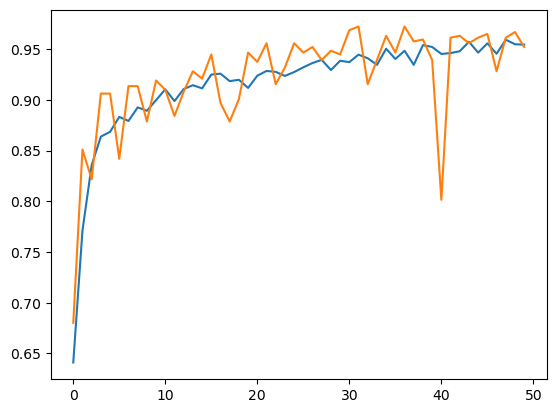

In [425]:
plt.plot(range(EPOCHS), epochs.history['accuracy'])
plt.plot(range(EPOCHS), epochs.history['val_accuracy'])

In [426]:
evaluation = model.evaluate(
    test_ds,
    batch_size=BATCH_SIZE,
    verbose=1,
)

print(f"Loss: {evaluation[0]}\nAccuracy: {evaluation[1]}")

19/19 [==============================] - 0s 8ms/step - loss: 0.1253 - accuracy: 0.9671
Loss: 0.12533727288246155
Accuracy: 0.967051088809967


In [427]:
# Function for inference
def predict(img):
    img = np.expand_dims(img, 0)
    predction = model.predict(img)[0]
    confidence = round(np.max(predction) * 100, 2)
    predction = CLASS_NAMES[np.argmax(predction)]
    return predction, confidence

1/1 [==============================] - 0s 12ms/step


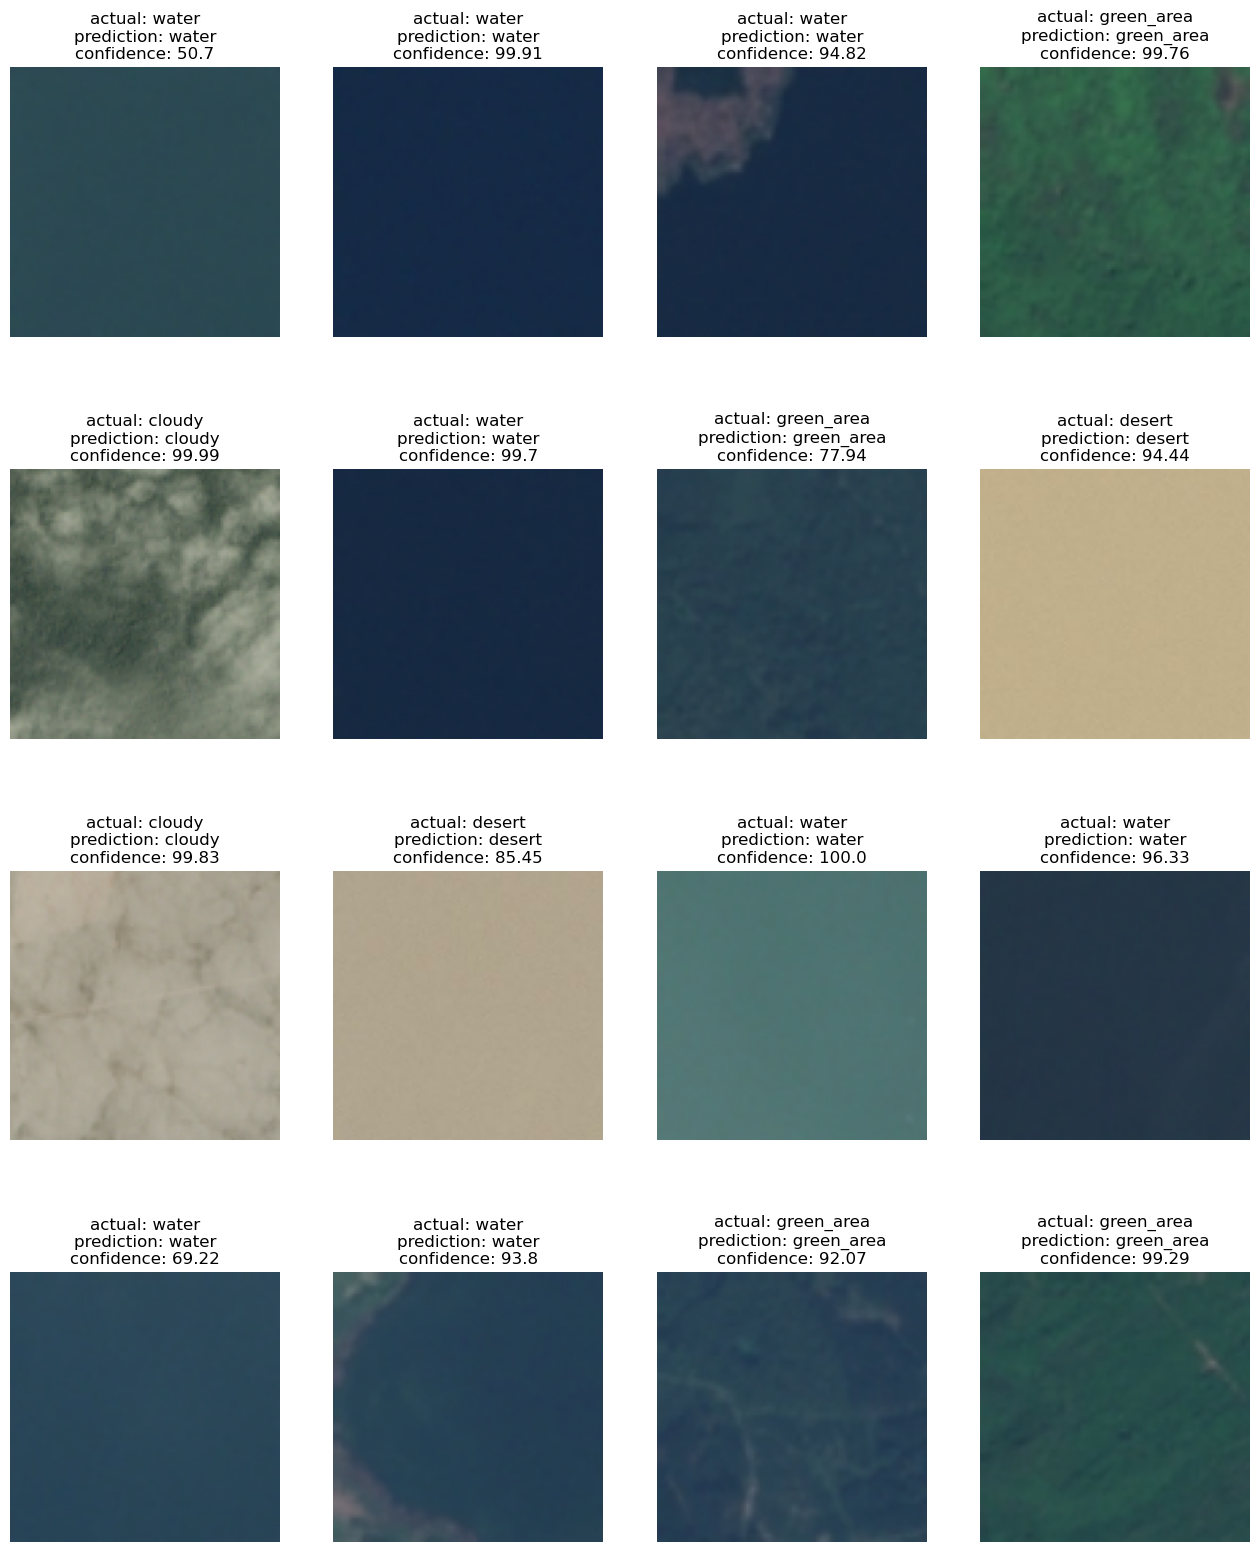

In [428]:
# Preview a few attempts to classify from the testing dataset
plt.figure(figsize=(16, 20))
for image_batch, label_batch in test_ds.take(1):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        prediction, confidence = predict(image_batch[i])
        plt.title(f"actual: {CLASS_NAMES[label_batch[i]]}\nprediction: {prediction}\nconfidence: {confidence}")
        plt.axis('off')

In [429]:
# Save the model (with an autorolling version)
import os
nums = [int(x) for x in os.listdir('../models/')]
model.save(f'../models/{max(nums) + 1 if nums else 0}')

INFO:tensorflow:Assets written to: ../models/5/assets


INFO:tensorflow:Assets written to: ../models/5/assets
